<a href="https://colab.research.google.com/github/mikful/dlai-tf-in-practice/blob/master/TensorFlow_in_Practice_Course_2_Week_4_Exercise_8_Sign_Language_Multi_class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import csv
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version: ', tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

TensorFlow 2.x selected.
TensorFlow version:  2.1.0


The data for this exercise is available at: https://www.kaggle.com/datamunge/sign-language-mnist/data

Sign up and download to find 2 CSV files: sign_mnist_test.csv and sign_mnist_train.csv -- You will upload both of them using this button before you can continue.


In [0]:
uploaded=files.upload()

In [0]:
 # Read image data from csv file - labels and pixel RGB values
  
  # The first line contains the column headers so ignore it
  # Each successive line contians 785 comma separated values between 0 and 255
  # The first value is the label
  # The rest are the pixel values for that picture
  # The function will return 2 np.array types. One with all the labels
  # One with all the images
  
  # Tips: 
  # If you read a full line (as 'row') then row[0] has the label
  # and row[1:785] has the 784 pixel values
  # Take a look at np.array_split to turn the 784 pixels into 28x28
  # You are reading in strings, but need the values to be floats
  # Check out np.array().astype for a conversion

def get_data(filename):
  with open(filename) as training_file:
    csv_reader = csv.reader(training_file, delimiter=',')
    first_line = True
    temp_images = []
    temp_labels = []
    for row in csv_reader:
      if first_line:
        # print("Ignoring first line")
        first_line = False
      else:
        temp_labels.append(row[0])
        image_data = row[1:785]
        image_data_as_array = np.array_split(image_data, 28)
        temp_images.append(image_data_as_array)
    images = np.array(temp_images).astype('float')
    labels = np.array(temp_labels).astype('float')
    
    return images, labels

In [33]:
# Convert csv data to image array/tensor

training_images, training_labels = get_data('/content/sign_mnist_train.csv')
testing_images, testing_labels = get_data('/content/sign_mnist_test.csv')

# Keep these
print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

# Their output should be:
# (27455, 28, 28)
# (27455,)
# (7172, 28, 28)
# (7172,)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [70]:
# Number labels (should be same)
unique_training_labels = set(training_labels)
unique_testing_labels = set(testing_labels)

if unique_training_labels == unique_testing_labels:
  num_labels = len(unique_training_labels)

print('# Training labels: ', len(unique_training_labels))
print('Training labels: ', unique_training_labels)
print('# Testing labels: ', len(unique_testing_labels))
print('Test labels: ', unique_testing_labels)

# Training labels:  24
Training labels:  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0}
# Testing labels:  24
Test labels:  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0}


In [0]:
# Add channel dimension to the data (and change dim value to grayscale = 1, RGB = 3)
# So, for example, if your array is (10000, 28, 28)
# You will need to make it (10000, 28, 28, 1)
# Hint: np.expand_dims

training_images = np.expand_dims(training_images, axis=3)
testing_images = np.expand_dims(testing_images, axis=3)

In [71]:
# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True
    )

validation_datagen = ImageDataGenerator(
    rescale = 1./255
    )

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow(training_images,
                                     training_labels,
                                     batch_size=32
                                     )     

# Flow validation images in batches using test_datagen generator
valid_generator =  validation_datagen.flow(testing_images,
                                     testing_labels,
                                     batch_size=32
                                     )
  
# Keep These
print(training_images.shape)
print(testing_images.shape)
    
# Their output should be:
# (27455, 28, 28, 1)
# (7172, 28, 28, 1)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [74]:
# Define the model
# Use no more than 2 Conv2D and 2 MaxPooling2D
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units= num_labels+1, activation='softmax')
    ])

# Compile Model.
model.compile(loss = 'sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# Steps per epcoh
steps_per_epoch = len(training_images) // train_generator.batch_size
validation_steps = len(testing_images) // valid_generator.batch_size

# Train the Model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=15,
                    validation_data=valid_generator,
                    validation_steps=validation_steps)

model.evaluate(testing_images, testing_labels)
    
# The output from model.evaluate should be close to:
[6.92426086682151, 0.56609035]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 857 steps, validate for 224 steps
Epoch 1/15
857/857 [==============================] - 52s 60ms/step - loss: 2.4929 - accuracy: 0.2349 - val_loss: 1.3560 - val_accuracy: 0.5310
Epoch 2/15
857/857 [==============================] - 51s 60ms/step - loss: 1.5521 - accuracy: 0.5015 - val_loss: 1.0192 - val_accuracy: 0.6168
Epoch 3/15
857/857 [==============================] - 51s 60ms/step - loss: 1.1796 - accuracy: 0.6137 - val_loss: 0.6830 - val_accuracy: 0.7480
Epoch 4/15
857/857 [==============================] - 51s 59ms/step - loss: 0.9452 - accuracy: 0.6873 - val_loss: 0.5849 - val_accuracy: 0.7959
Epoch 5/15
857/857 [==============================] - 51s 60ms/step - loss: 0.8003 - accuracy: 0.7350 - val_loss: 0.4270 - val_accuracy: 0.8622
Epoch 6/15
857/857 [==============================] - 51s 59ms/step - loss: 0.6997 - accuracy: 0.7663 - val_loss: 0.3388 - val_accuracy: 0.8867
Epoch 7/15
857/857 [======================

[6.92426086682151, 0.56609035]

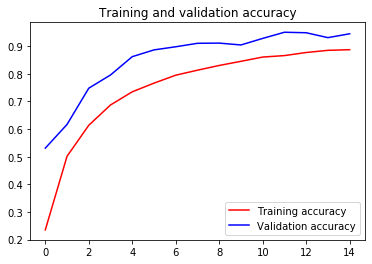

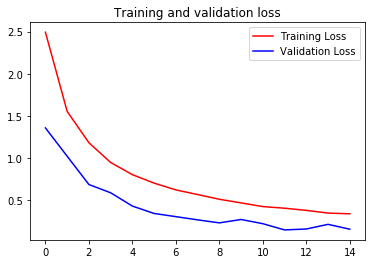

In [76]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()